# Exercise: Earthquake Location Using Travel Time Tomography

**Objective:** Learn how to locate an earthquake using travel times computed with PyKonal in a 3D heterogeneous velocity model.

This is a test Marine made that will use subduction zone velocity models, configuration from the PNSN networks, and a guessed event on the deformation front of Cascadia to estimate uncertainty in error location solely based on travel time estimates.

## Learning Goals:
1. Create a realistic 3D velocity model with depth-dependent and lateral variations
2. Forward problem: Compute synthetic travel times from a known earthquake location
3. Inverse problem: Locate the earthquake using grid search or optimization
4. Analyze location uncertainty and trade-offs
5. Understand the impact of velocity model errors on location accuracy

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pykonal
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator

print(f"PyKonal version: {pykonal.__version__}")
print("Setup complete!")

PyKonal version: 0.4.1
Setup complete!


## 2. Create 3D Velocity Model

We'll create a velocity model with:
- **Depth dependence**: Velocity increases with depth (typical of Earth structure)
- **Lateral variations**: Smooth sinusoidal variations representing geological structures
- **Domain**: 20 km × 20 km × 10 km depth

In [10]:
# Define 3D model domain for subduction zone
nx, ny, nz = 101, 101, 101  # Grid points
x_min, x_max = -50.0, 50.0   # km (100 km total)
y_min, y_max = -50.0, 50.0   # km (100 km total)
z_min, z_max = 0.0, 100.0    # km depth (100 km total, positive downward)

# Create coordinate arrays
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
z = np.linspace(z_min, z_max, nz)

# Create 3D meshgrid
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Create subduction zone velocity model
# Base velocity: typical oceanic/continental crust and mantle structure
v_surface = 4.5  # km/s - crustal velocity
v_mantle = 8.0   # km/s - mantle velocity
moho_depth = 35.0  # km - Moho discontinuity

# Start with depth-dependent background velocity
velocity_3d = np.where(Z < moho_depth,
                       v_surface + (v_mantle - v_surface) * (Z / moho_depth)**2,
                       v_mantle + 0.05 * (Z - moho_depth))

# Add high-velocity subducting slab
# Slab geometry: dipping plane
slab_dip = 45.0  # degrees
slab_thickness = 8.0  # km
slab_x_position = 0.0  # km - where slab starts at surface

# Convert dip to radians
dip_rad = np.radians(slab_dip)

# Calculate distance from slab plane
# Slab equation: z = (x - slab_x_position) * tan(dip) for y near 0
# Distance to slab center for each point
slab_center_depth = (X - slab_x_position) * np.tan(dip_rad)
distance_to_slab = Z - slab_center_depth

# Create slab mask (where distance is small)
in_slab = (np.abs(distance_to_slab) < slab_thickness / 2) & (X > slab_x_position) & (Z > 0)

# Slab velocity anomaly: +8-10% higher velocity (colder slab)
slab_velocity_anomaly = 0.65  # km/s increase

# Apply slab velocity anomaly with smooth taper
taper = np.exp(-((distance_to_slab / (slab_thickness / 2))**2))
velocity_3d = np.where(in_slab, 
                       velocity_3d + slab_velocity_anomaly * taper,
                       velocity_3d)

# Add low-velocity mantle wedge above the slab (deeper structure)
wedge_x_min = slab_x_position - 30.0  # km
wedge_depth_max = 80.0  # km
in_wedge = (X < slab_x_position) & (X > wedge_x_min) & (Z > moho_depth) & (Z < wedge_depth_max)
wedge_velocity_reduction = -0.4  # km/s decrease (partial melt, hydration)

# Smooth wedge anomaly that decreases away from slab
wedge_distance = np.sqrt((X - slab_x_position)**2 + (Z - slab_center_depth)**2)
wedge_taper = np.exp(-(wedge_distance / 20.0)**2)
velocity_3d = np.where(in_wedge,
                       velocity_3d + wedge_velocity_reduction * wedge_taper,
                       velocity_3d)

# Add accretionary wedge: low-velocity sedimentary complex above the slab interface
# This is shallower and has even lower velocities than the mantle wedge
accretionary_x_min = slab_x_position - 40.0  # km (extends further seaward)
accretionary_x_max = slab_x_position + 10.0  # km (extends slightly landward of trench)
accretionary_depth_max = 25.0  # km (shallower than mantle wedge)
accretionary_thickness = 8.0  # km (thickness of the wedge)

# Define accretionary wedge geometry
# It sits above the slab interface and tapers both upward and seaward
slab_top_depth = slab_center_depth - slab_thickness/2  # Top of slab
accretionary_top = np.maximum(0, slab_top_depth - accretionary_thickness)  # Top of accretionary wedge

# Mask for accretionary wedge
in_accretionary = ((X >= accretionary_x_min) & (X <= accretionary_x_max) & 
                   (Z >= accretionary_top) & (Z <= slab_top_depth) &
                   (Z <= accretionary_depth_max))

# Lower velocities in accretionary wedge (unconsolidated sediments)
accretionary_velocity_reduction = -2.2  # km/s (significant reduction for sediments)

# Taper the velocity reduction based on distance from slab and depth
# Stronger reduction near the slab interface, weaker toward edges
distance_from_slab_top = np.abs(Z - slab_top_depth)
lateral_distance = np.abs(X - (accretionary_x_min + accretionary_x_max) / 2)
accretionary_taper = (np.exp(-distance_from_slab_top / 3.0) * 
                      np.exp(-lateral_distance / 15.0) *
                      (1 - Z / accretionary_depth_max))  # Taper with depth

velocity_3d = np.where(in_accretionary,
                       velocity_3d + accretionary_velocity_reduction * accretionary_taper,
                       velocity_3d)

# Add some 3D structure: along-strike variation (in y-direction)
along_strike_variation = 0.15 * np.sin(2 * np.pi * Y / 40.0) * np.exp(-Z / 50.0)
velocity_3d += along_strike_variation

# Ensure velocities are within reasonable bounds
velocity_3d = np.clip(velocity_3d, 3.5, 9.0)

print(f"Subduction zone velocity model created")
print(f"  Domain: [{x_min}, {x_max}] × [{y_min}, {y_max}] × [{z_min}, {z_max}] km")
print(f"  Grid size: {nx} × {ny} × {nz}")
print(f"  Grid spacing: {(x_max-x_min)/(nx-1):.2f} × {(y_max-y_min)/(ny-1):.2f} × {(z_max-z_min)/(nz-1):.2f} km")
print(f"  Velocity range: {velocity_3d.min():.2f} - {velocity_3d.max():.2f} km/s")
print(f"\nSubduction zone features:")
print(f"  Slab dip angle: {slab_dip}°")
print(f"  Slab thickness: {slab_thickness} km")
print(f"  Moho depth: {moho_depth} km")
print(f"  Slab velocity anomaly: +{slab_velocity_anomaly:.2f} km/s")
print(f"  Mantle wedge velocity reduction: {wedge_velocity_reduction:.2f} km/s")
print(f"  Accretionary wedge velocity reduction: {accretionary_velocity_reduction:.2f} km/s")
print(f"  Accretionary wedge max depth: {accretionary_depth_max} km")
print(f"  Accretionary wedge thickness: {accretionary_thickness} km")

Subduction zone velocity model created
  Domain: [-50.0, 50.0] × [-50.0, 50.0] × [0.0, 100.0] km
  Grid size: 101 × 101 × 101
  Grid spacing: 1.00 × 1.00 × 1.00 km
  Velocity range: 3.93 - 9.00 km/s

Subduction zone features:
  Slab dip angle: 45.0°
  Slab thickness: 8.0 km
  Moho depth: 35.0 km
  Slab velocity anomaly: +0.65 km/s
  Mantle wedge velocity reduction: -0.40 km/s
  Accretionary wedge velocity reduction: -2.20 km/s
  Accretionary wedge max depth: 25.0 km
  Accretionary wedge thickness: 8.0 km


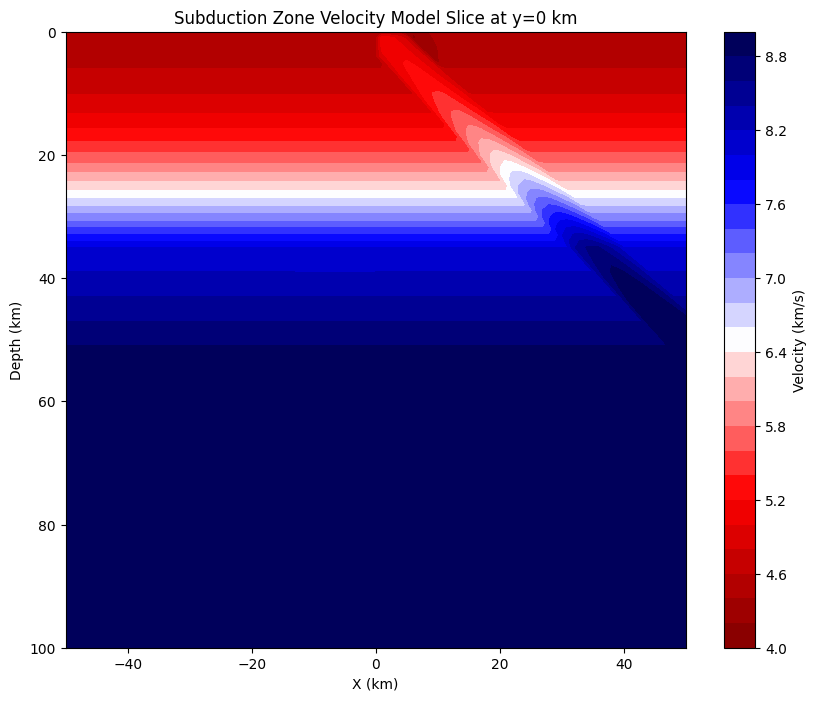

In [11]:
# plot the background 3D velocity model without slab and wedge for reference
plt.figure(figsize=(10, 8))
# Slice at y=0
y_index = ny // 2
plt.contourf(X[:, y_index, :], Z[:, y_index, :], velocity_3d[:, y_index, :], levels=25, cmap='seismic_r')
plt.colorbar(label='Velocity (km/s)')
plt.title('Subduction Zone Velocity Model Slice at y=0 km')
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.gca().invert_yaxis()
plt.show()

### Visualize the Velocity Model

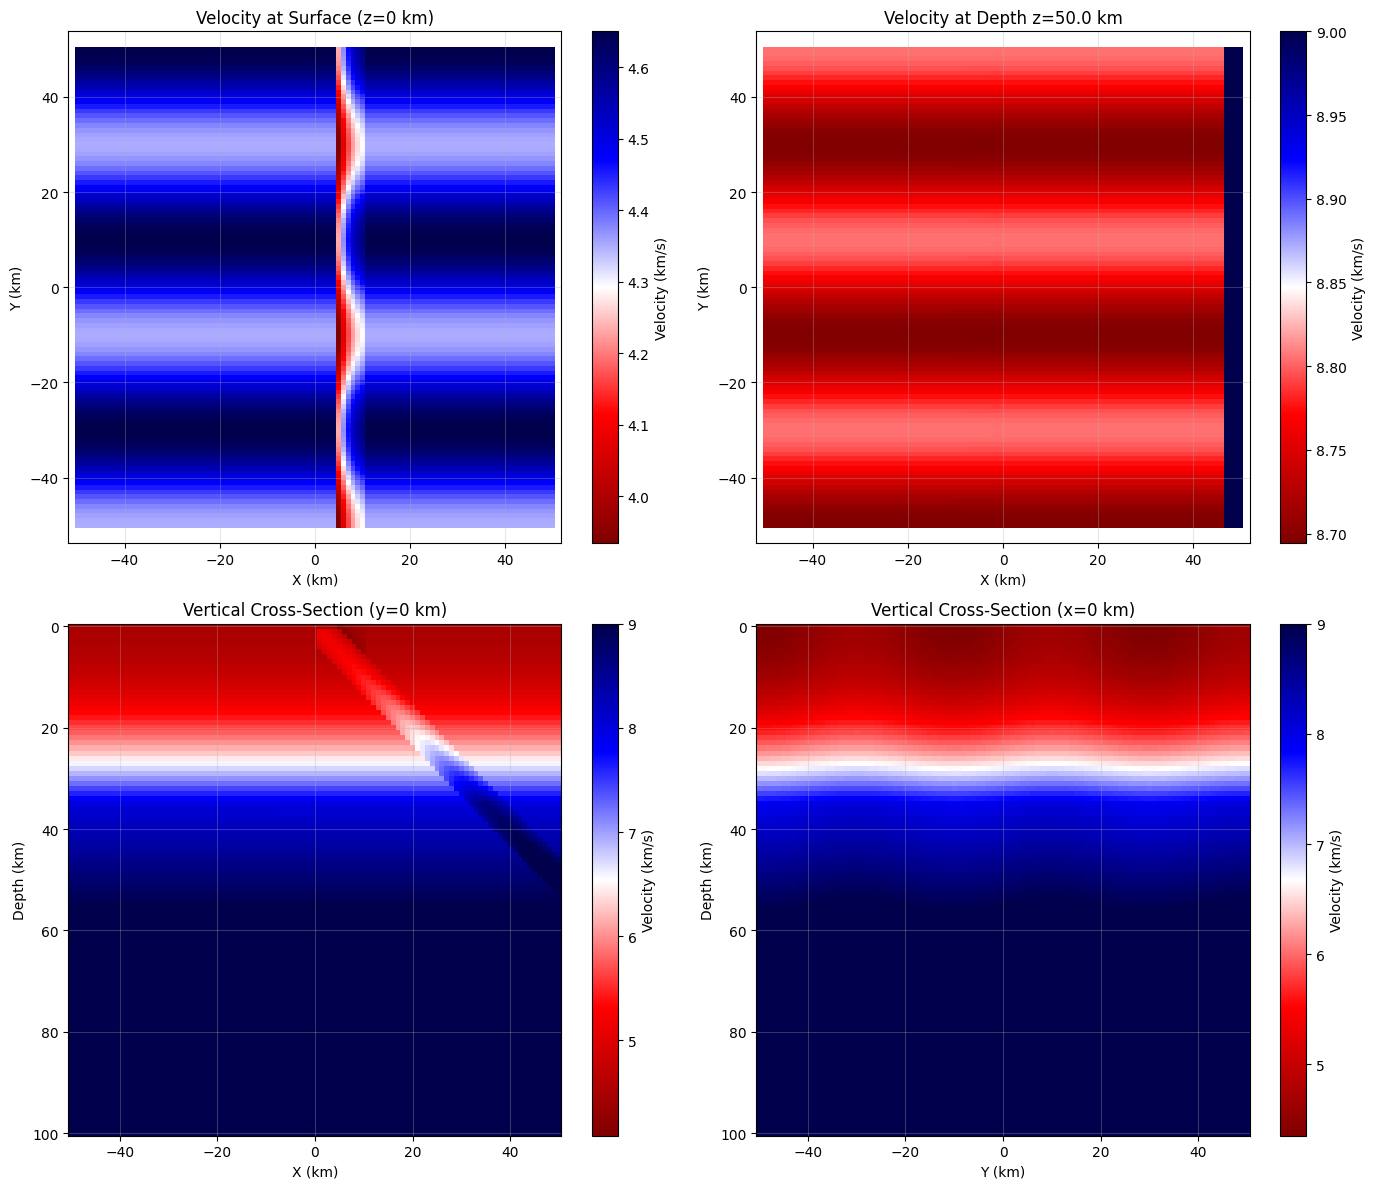

In [12]:
# Plot velocity model slices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Surface slice (z=0)
ax = axes[0, 0]
im = ax.pcolormesh(X[:, :, 0], Y[:, :, 0], velocity_3d[:, :, 0], 
                   shading='auto', cmap='seismic_r')
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title('Velocity at Surface (z=0 km)')
ax.axis('equal')
ax.grid(True, alpha=0.3)

# Mid-depth slice (z=5 km)
ax = axes[0, 1]
mid_z_idx = nz // 2
im = ax.pcolormesh(X[:, :, mid_z_idx], Y[:, :, mid_z_idx], velocity_3d[:, :, mid_z_idx], 
                   shading='auto', cmap='seismic_r')
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title(f'Velocity at Depth z={z[mid_z_idx]:.1f} km')
ax.axis('equal')
ax.grid(True, alpha=0.3)

# Vertical slice at y=0
ax = axes[1, 0]
y_mid_idx = ny // 2
im = ax.pcolormesh(X[:, y_mid_idx, :], Z[:, y_mid_idx, :], velocity_3d[:, y_mid_idx, :], 
                   shading='auto', cmap='seismic_r')
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('Vertical Cross-Section (y=0 km)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# Vertical slice at x=0
ax = axes[1, 1]
x_mid_idx = nx // 2
im = ax.pcolormesh(Y[x_mid_idx, :, :], Z[x_mid_idx, :, :], velocity_3d[x_mid_idx, :, :], 
                   shading='auto', cmap='seismic_r')
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('Y (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('Vertical Cross-Section (x=0 km)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Define True Earthquake Location and Sensor Array

We'll place:
- **Earthquake**: At some depth within the model
- **Sensors**: At the surface (z=0) in a regular grid

In [4]:
# TRUE earthquake location (this is what we'll try to recover)
true_eq_x = 2.5   # km
true_eq_y = -3.0  # km
true_eq_z = 6.0   # km depth
true_eq_location = np.array([true_eq_x, true_eq_y, true_eq_z])

print(f"True earthquake location: ({true_eq_x:.2f}, {true_eq_y:.2f}, {true_eq_z:.2f}) km")

# Create sensor array at surface (z=0)
sensor_spacing = 2.0  # km
x_sensors = np.arange(-8, 8.1, sensor_spacing)
y_sensors = np.arange(-8, 8.1, sensor_spacing)
X_sensors, Y_sensors = np.meshgrid(x_sensors, y_sensors)
Z_sensors = np.zeros_like(X_sensors)  # All at surface

# Flatten sensor coordinates
sensor_coords = np.column_stack([
    X_sensors.ravel(),
    Y_sensors.ravel(),
    Z_sensors.ravel()
])
n_sensors = len(sensor_coords)

print(f"Number of sensors: {n_sensors}")
print(f"Sensor spacing: {sensor_spacing} km")
print(f"All sensors at surface (z=0 km)")

True earthquake location: (2.50, -3.00, 6.00) km
Number of sensors: 81
Sensor spacing: 2.0 km
All sensors at surface (z=0 km)


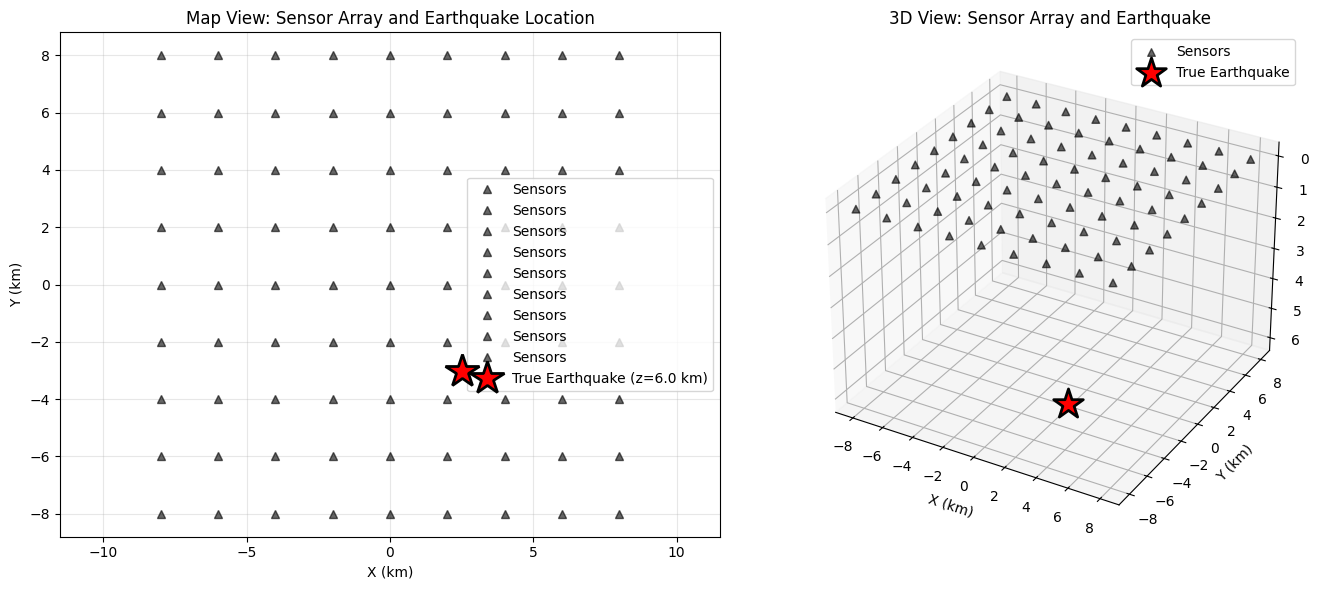

In [5]:
# Visualize sensor array and true earthquake location
fig = plt.figure(figsize=(14, 6))

# 2D map view
ax1 = fig.add_subplot(121)
ax1.plot(X_sensors, Y_sensors, 'k^', markersize=6, alpha=0.6, label='Sensors')
ax1.plot(true_eq_x, true_eq_y, 'r*', markersize=25, markeredgecolor='black', 
         markeredgewidth=2, label=f'True Earthquake (z={true_eq_z} km)', zorder=10)
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title('Map View: Sensor Array and Earthquake Location')
ax1.axis('equal')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 3D view
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_sensors, Y_sensors, Z_sensors, c='black', marker='^', s=30, alpha=0.6, label='Sensors')
ax2.scatter(true_eq_x, true_eq_y, true_eq_z, c='red', marker='*', s=500, 
            edgecolors='black', linewidths=2, label='True Earthquake', zorder=10)
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Y (km)')
ax2.set_zlabel('Depth (km)')
ax2.set_title('3D View: Sensor Array and Earthquake')
ax2.invert_zaxis()
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Forward Problem: Compute Synthetic Travel Times

Using PyKonal, we'll:
1. Solve the eikonal equation from the true earthquake location
2. Extract travel times at each sensor
3. Add realistic noise to simulate observational uncertainty

In [6]:
# Setup PyKonal solver
print("Setting up PyKonal solver...")
solver = pykonal.EikonalSolver(coord_sys="cartesian")

# Define the grid
solver.velocity.min_coords = x_min, y_min, z_min
solver.velocity.node_intervals = (x_max - x_min) / (nx - 1), (y_max - y_min) / (ny - 1), (z_max - z_min) / (nz - 1)
solver.velocity.npts = nx, ny, nz

# Set velocity model
solver.velocity.values = velocity_3d

# Set source location (true earthquake)
src_idx = (
    int((true_eq_x - x_min) / (x_max - x_min) * (nx - 1)),
    int((true_eq_y - y_min) / (y_max - y_min) * (ny - 1)),
    int((true_eq_z - z_min) / (z_max - z_min) * (nz - 1))
)

solver.traveltime.values[src_idx] = 0.0
solver.unknown[src_idx] = False
solver.trial.push(*src_idx)

print(f"Source index: {src_idx}")
print(f"Velocity at source: {velocity_3d[src_idx]:.2f} km/s")
print("Solver configured successfully!")

Setting up PyKonal solver...
Source index: (62, 35, 30)
Velocity at source: 3.86 km/s
Solver configured successfully!


In [7]:
# Solve the eikonal equation
print("Solving eikonal equation...")
solver.solve()
print("Done!")

Solving eikonal equation...
Done!


In [8]:
# Extract travel times at sensor locations
interpolator = RegularGridInterpolator(
    (x, y, z), 
    solver.traveltime.values, 
    method='linear', 
    bounds_error=False
)

true_travel_times = interpolator(sensor_coords)

# Add Gaussian noise to simulate measurement uncertainty
noise_level = 0.05  # seconds (50 ms)
np.random.seed(42)  # For reproducibility
noise = np.random.normal(0, noise_level, len(true_travel_times))
observed_travel_times = true_travel_times + noise

print(f"\nTravel time statistics:")
print(f"  Range: {true_travel_times.min():.3f} - {true_travel_times.max():.3f} s")
print(f"  Mean: {true_travel_times.mean():.3f} s")
print(f"  Added noise level: {noise_level:.3f} s (Gaussian)")
print(f"  Observed range: {observed_travel_times.min():.3f} - {observed_travel_times.max():.3f} s")


Travel time statistics:
  Range: 1.805 - 4.676 s
  Mean: 2.890 s
  Added noise level: 0.050 s (Gaussian)
  Observed range: 1.786 - 4.674 s


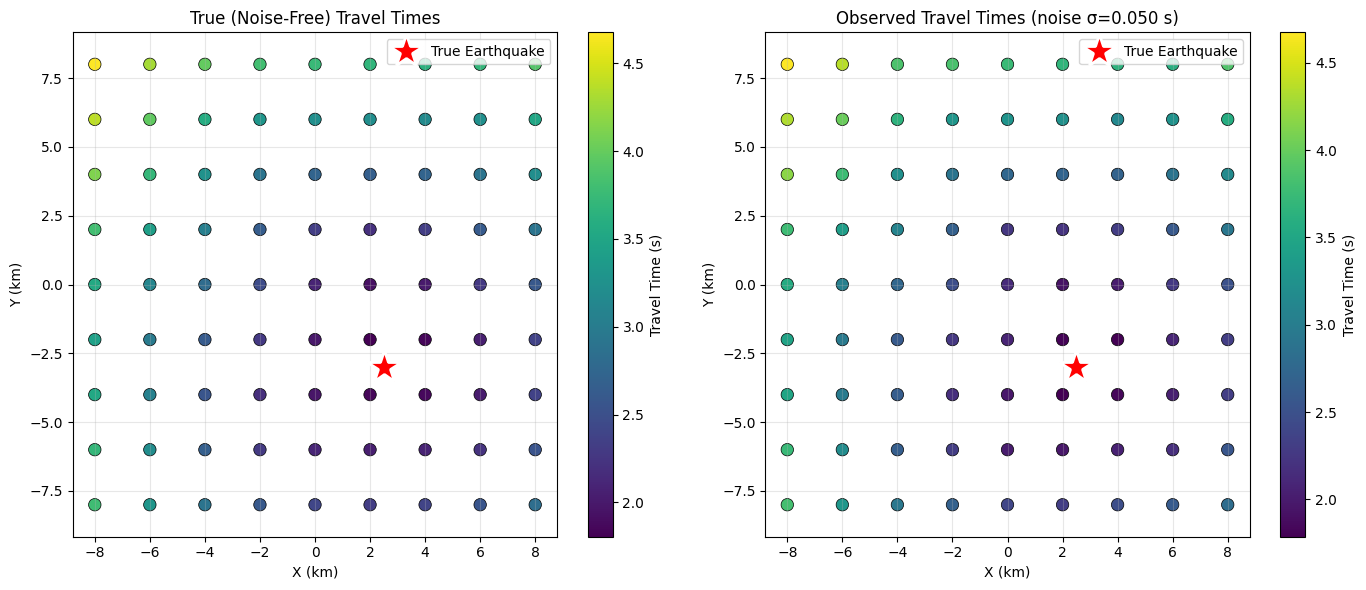

In [9]:
# Visualize observed travel times
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: True travel times
ax = axes[0]
scatter = ax.scatter(X_sensors, Y_sensors, c=true_travel_times.reshape(X_sensors.shape), 
                    s=80, cmap='viridis', edgecolors='black', linewidths=0.5)
ax.plot(true_eq_x, true_eq_y, 'r*', markersize=25, markeredgecolor='white', 
        markeredgewidth=2, label='True Earthquake', zorder=10)
plt.colorbar(scatter, ax=ax, label='Travel Time (s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title('True (Noise-Free) Travel Times')
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 2: Observed travel times (with noise)
ax = axes[1]
scatter = ax.scatter(X_sensors, Y_sensors, c=observed_travel_times.reshape(X_sensors.shape), 
                    s=80, cmap='viridis', edgecolors='black', linewidths=0.5)
ax.plot(true_eq_x, true_eq_y, 'r*', markersize=25, markeredgecolor='white', 
        markeredgewidth=2, label='True Earthquake', zorder=10)
plt.colorbar(scatter, ax=ax, label='Travel Time (s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title(f'Observed Travel Times (noise σ={noise_level:.3f} s)')
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 5. Inverse Problem: Earthquake Location

Now we'll try to locate the earthquake using only the observed travel times. We'll implement two approaches:

### 5.1 Grid Search Method

The simplest approach: evaluate the misfit function on a regular grid and find the minimum.

In [10]:
def compute_predicted_times(source_location, sensor_coords, velocity_model, x, y, z):
    """
    Compute predicted travel times from a trial source location to all sensors.
    
    Parameters:
    -----------
    source_location : array [x, y, z] in km
    sensor_coords : array of sensor positions (n_sensors, 3)
    velocity_model : 3D velocity array
    x, y, z : coordinate arrays for the grid
    
    Returns:
    --------
    predicted_times : array of travel times (n_sensors,)
    """
    # Setup PyKonal solver
    solver_trial = pykonal.EikonalSolver(coord_sys="cartesian")
    solver_trial.velocity.min_coords = x.min(), y.min(), z.min()
    solver_trial.velocity.node_intervals = (
        (x.max() - x.min()) / (len(x) - 1),
        (y.max() - y.min()) / (len(y) - 1),
        (z.max() - z.min()) / (len(z) - 1)
    )
    solver_trial.velocity.npts = len(x), len(y), len(z)
    solver_trial.velocity.values = velocity_model
    
    # Set trial source
    src_x, src_y, src_z = source_location
    src_idx = (
        int((src_x - x.min()) / (x.max() - x.min()) * (len(x) - 1)),
        int((src_y - y.min()) / (y.max() - y.min()) * (len(y) - 1)),
        int((src_z - z.min()) / (z.max() - z.min()) * (len(z) - 1))
    )
    
    # Handle boundary cases
    src_idx = (
        max(0, min(src_idx[0], len(x) - 1)),
        max(0, min(src_idx[1], len(y) - 1)),
        max(0, min(src_idx[2], len(z) - 1))
    )
    
    solver_trial.traveltime.values[src_idx] = 0.0
    solver_trial.unknown[src_idx] = False
    solver_trial.trial.push(*src_idx)
    
    # Solve
    solver_trial.solve()
    
    # Interpolate at sensor locations
    interpolator = RegularGridInterpolator(
        (x, y, z),
        solver_trial.traveltime.values,
        method='linear',
        bounds_error=False,
        fill_value=np.inf
    )
    
    predicted_times = interpolator(sensor_coords)
    return predicted_times

def misfit_function(source_location, sensor_coords, observed_times, velocity_model, x, y, z):
    """
    Compute L2 misfit between observed and predicted travel times.
    """
    predicted_times = compute_predicted_times(source_location, sensor_coords, velocity_model, x, y, z)
    residuals = observed_times - predicted_times
    misfit = np.sqrt(np.nanmean(residuals**2))  # RMS residual
    return misfit

print("Functions defined successfully!")

Functions defined successfully!


In [11]:
# Perform grid search (coarse grid for efficiency)
print("Performing grid search...")
print("This may take a few minutes...\n")

# Define search grid (coarser than model grid)
search_x = np.linspace(-8, 8, 9)  # 9 points
search_y = np.linspace(-8, 8, 9)  # 9 points
search_z = np.linspace(2, 8, 7)   # 7 points (search only at depth)

n_search = len(search_x) * len(search_y) * len(search_z)
print(f"Grid search points: {len(search_x)} × {len(search_y)} × {len(search_z)} = {n_search}")

# Initialize misfit grid
misfit_grid = np.zeros((len(search_x), len(search_y), len(search_z)))

# Loop over search grid
counter = 0
for i, sx in enumerate(search_x):
    for j, sy in enumerate(search_y):
        for k, sz in enumerate(search_z):
            counter += 1
            if counter % 50 == 0:
                print(f"  Progress: {counter}/{n_search} ({100*counter/n_search:.1f}%)")
            
            trial_location = np.array([sx, sy, sz])
            misfit_grid[i, j, k] = misfit_function(
                trial_location, sensor_coords, observed_travel_times, 
                velocity_3d, x, y, z
            )

# Find minimum misfit location
min_idx = np.unravel_index(np.argmin(misfit_grid), misfit_grid.shape)
located_x = search_x[min_idx[0]]
located_y = search_y[min_idx[1]]
located_z = search_z[min_idx[2]]
min_misfit = misfit_grid[min_idx]

print(f"\nGrid search complete!")
print(f"\nTrue location:    ({true_eq_x:.2f}, {true_eq_y:.2f}, {true_eq_z:.2f}) km")
print(f"Located position: ({located_x:.2f}, {located_y:.2f}, {located_z:.2f}) km")
print(f"\nLocation error:")
print(f"  Horizontal: {np.sqrt((located_x - true_eq_x)**2 + (located_y - true_eq_y)**2):.2f} km")
print(f"  Vertical:   {abs(located_z - true_eq_z):.2f} km")
print(f"  Total 3D:   {np.sqrt((located_x - true_eq_x)**2 + (located_y - true_eq_y)**2 + (located_z - true_eq_z)**2):.2f} km")
print(f"\nMinimum RMS misfit: {min_misfit:.4f} s")

Performing grid search...
This may take a few minutes...

Grid search points: 9 × 9 × 7 = 567
  Progress: 50/567 (8.8%)
  Progress: 100/567 (17.6%)
  Progress: 150/567 (26.5%)
  Progress: 200/567 (35.3%)
  Progress: 250/567 (44.1%)
  Progress: 300/567 (52.9%)
  Progress: 350/567 (61.7%)
  Progress: 400/567 (70.5%)
  Progress: 450/567 (79.4%)
  Progress: 500/567 (88.2%)
  Progress: 550/567 (97.0%)

Grid search complete!

True location:    (2.50, -3.00, 6.00) km
Located position: (2.00, -4.00, 6.00) km

Location error:
  Horizontal: 1.12 km
  Vertical:   0.00 km
  Total 3D:   1.12 km

Minimum RMS misfit: 0.1748 s


### Visualize Grid Search Results

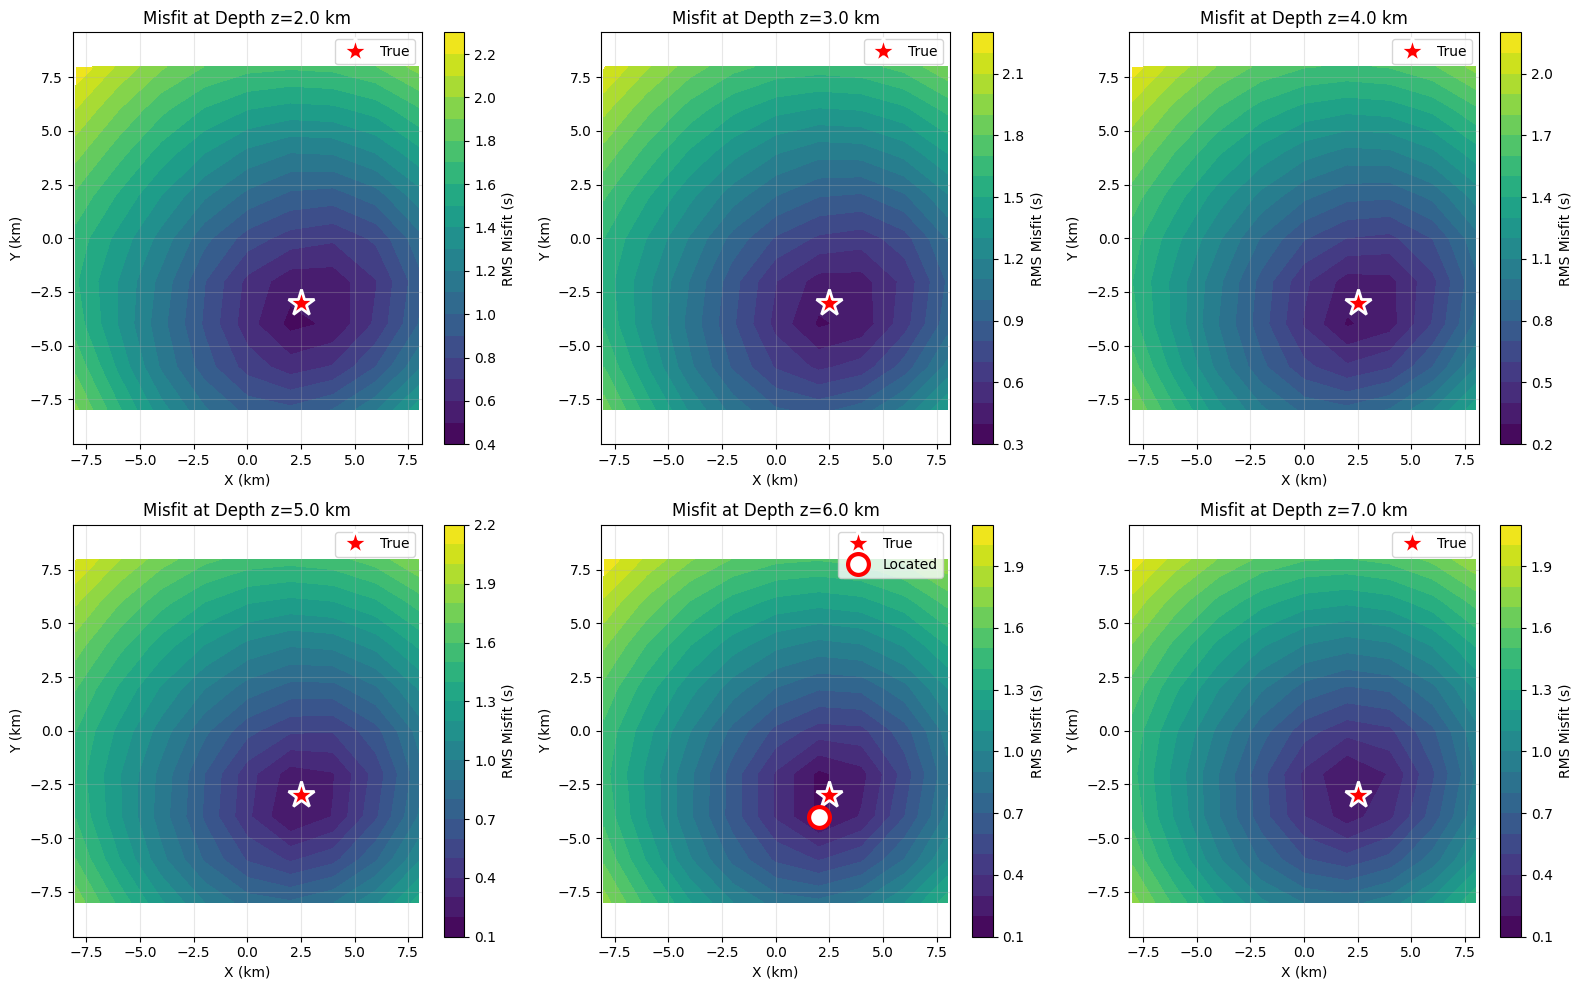

In [12]:
# Plot misfit for different depth slices
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for k in range(len(search_z)):
    if k < len(axes):
        ax = axes[k]
        im = ax.contourf(search_x, search_y, misfit_grid[:, :, k].T, 
                        levels=20, cmap='viridis')
        ax.plot(true_eq_x, true_eq_y, 'r*', markersize=20, 
               markeredgecolor='white', markeredgewidth=2, label='True')
        if search_z[k] == located_z:
            ax.plot(located_x, located_y, 'wo', markersize=15, 
                   markeredgecolor='red', markeredgewidth=3, label='Located')
        plt.colorbar(im, ax=ax, label='RMS Misfit (s)')
        ax.set_xlabel('X (km)')
        ax.set_ylabel('Y (km)')
        ax.set_title(f'Misfit at Depth z={search_z[k]:.1f} km')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
        ax.legend()

plt.tight_layout()
plt.show()

### 5.2 Optimization-Based Location (Nonlinear Least Squares)

Use scipy's optimization to refine the location estimate. This is faster but requires a good initial guess.

In [13]:
# Use grid search result as initial guess
initial_guess = np.array([located_x, located_y, located_z])

print(f"Starting optimization from grid search result: ({located_x:.2f}, {located_y:.2f}, {located_z:.2f}) km")
print("Optimizing...\n")

# Define objective function for optimization
def objective(x):
    return misfit_function(x, sensor_coords, observed_travel_times, velocity_3d, x_array, y_array, z_array)

# Store arrays for use in objective function
x_array, y_array, z_array = x, y, z

# Optimize using Nelder-Mead (derivative-free method)
result = minimize(
    objective,
    initial_guess,
    method='Nelder-Mead',
    options={'maxiter': 100, 'xatol': 0.1, 'fatol': 0.001}
)

optimized_location = result.x
optimized_misfit = result.fun

print(f"Optimization complete!")
print(f"\nTrue location:      ({true_eq_x:.2f}, {true_eq_y:.2f}, {true_eq_z:.2f}) km")
print(f"Optimized location: ({optimized_location[0]:.2f}, {optimized_location[1]:.2f}, {optimized_location[2]:.2f}) km")
print(f"\nLocation error:")
print(f"  Horizontal: {np.sqrt((optimized_location[0] - true_eq_x)**2 + (optimized_location[1] - true_eq_y)**2):.2f} km")
print(f"  Vertical:   {abs(optimized_location[2] - true_eq_z):.2f} km")
print(f"  Total 3D:   {np.linalg.norm(optimized_location - true_eq_location):.2f} km")
print(f"\nOptimized RMS misfit: {optimized_misfit:.4f} s")
print(f"Improvement over grid search: {(min_misfit - optimized_misfit)*1000:.2f} ms")

Starting optimization from grid search result: (2.00, -4.00, 6.00) km
Optimizing...

Optimization complete!

True location:      (2.50, -3.00, 6.00) km
Optimized location: (2.23, -2.80, 6.05) km

Location error:
  Horizontal: 0.33 km
  Vertical:   0.05 km
  Total 3D:   0.34 km

Optimized RMS misfit: 0.0570 s
Improvement over grid search: 117.81 ms


## 6. Analyze Location Uncertainty

Let's understand the uncertainty in our location estimate by:
1. Examining the misfit landscape
2. Computing confidence regions
3. Analyzing trade-offs between x, y, and z

In [14]:
# Create finer grid around optimized location for uncertainty analysis
dx, dy, dz = 2.0, 2.0, 1.5  # km
fine_x = np.linspace(optimized_location[0] - dx, optimized_location[0] + dx, 15)
fine_y = np.linspace(optimized_location[1] - dy, optimized_location[1] + dy, 15)
fine_z = np.linspace(max(z_min, optimized_location[2] - dz), 
                     min(z_max, optimized_location[2] + dz), 11)

print(f"Computing fine misfit grid for uncertainty analysis...")
print(f"Grid: {len(fine_x)} × {len(fine_y)} × {len(fine_z)} = {len(fine_x)*len(fine_y)*len(fine_z)} points\n")

fine_misfit = np.zeros((len(fine_x), len(fine_y), len(fine_z)))

counter = 0
total = len(fine_x) * len(fine_y) * len(fine_z)
for i, fx in enumerate(fine_x):
    for j, fy in enumerate(fine_y):
        for k, fz in enumerate(fine_z):
            counter += 1
            if counter % 200 == 0:
                print(f"  Progress: {counter}/{total} ({100*counter/total:.1f}%)")
            
            trial_location = np.array([fx, fy, fz])
            fine_misfit[i, j, k] = misfit_function(
                trial_location, sensor_coords, observed_travel_times,
                velocity_3d, x, y, z
            )

print("\nFine grid computed!")

Computing fine misfit grid for uncertainty analysis...
Grid: 15 × 15 × 11 = 2475 points

  Progress: 200/2475 (8.1%)
  Progress: 400/2475 (16.2%)
  Progress: 600/2475 (24.2%)
  Progress: 800/2475 (32.3%)
  Progress: 1000/2475 (40.4%)
  Progress: 1200/2475 (48.5%)
  Progress: 1400/2475 (56.6%)
  Progress: 1600/2475 (64.6%)
  Progress: 1800/2475 (72.7%)
  Progress: 2000/2475 (80.8%)
  Progress: 2200/2475 (88.9%)
  Progress: 2400/2475 (97.0%)

Fine grid computed!


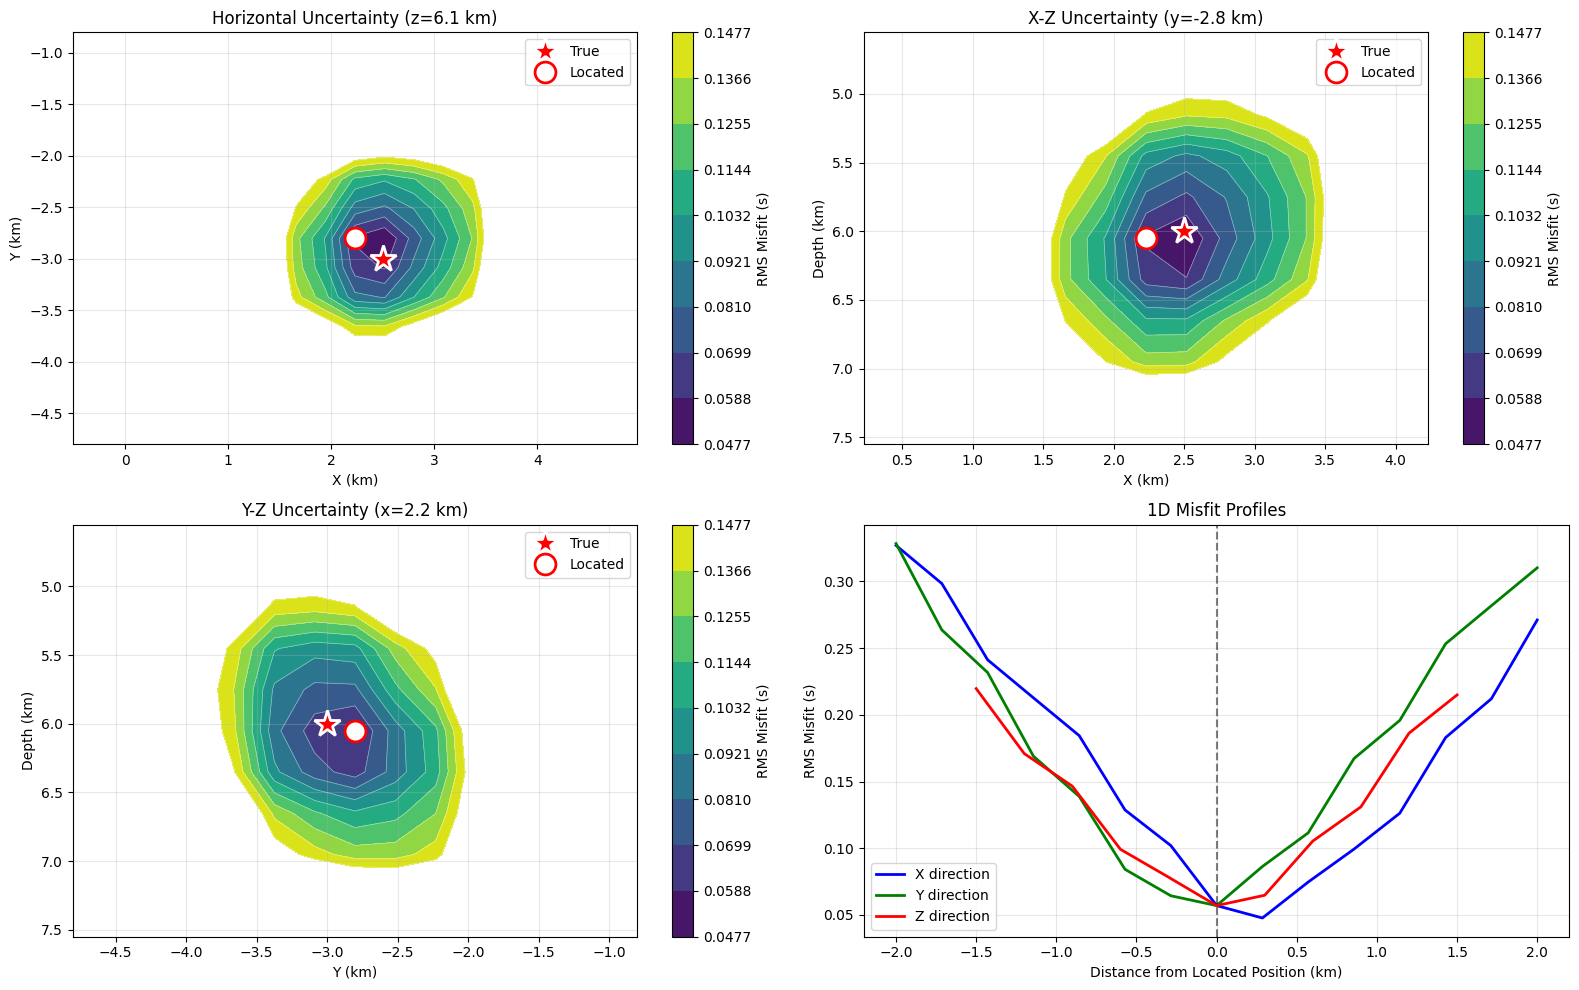

In [15]:
# Plot uncertainty: misfit contours at different confidence levels
fig = plt.figure(figsize=(16, 10))

# Find index closest to optimized depth
z_opt_idx = np.argmin(np.abs(fine_z - optimized_location[2]))

# Plot 1: Map view at optimized depth
ax1 = fig.add_subplot(221)
FX, FY = np.meshgrid(fine_x, fine_y)
levels = np.linspace(fine_misfit.min(), fine_misfit.min() + 0.1, 10)
cs = ax1.contourf(FX, FY, fine_misfit[:, :, z_opt_idx].T, levels=levels, cmap='viridis')
ax1.contour(FX, FY, fine_misfit[:, :, z_opt_idx].T, levels=levels, colors='white', linewidths=0.5, alpha=0.5)
ax1.plot(true_eq_x, true_eq_y, 'r*', markersize=20, markeredgecolor='white', 
         markeredgewidth=2, label='True', zorder=10)
ax1.plot(optimized_location[0], optimized_location[1], 'wo', markersize=15, 
         markeredgecolor='red', markeredgewidth=2, label='Located', zorder=10)
plt.colorbar(cs, ax=ax1, label='RMS Misfit (s)')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title(f'Horizontal Uncertainty (z={fine_z[z_opt_idx]:.1f} km)')
ax1.axis('equal')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: X-Z cross-section at optimized Y
ax2 = fig.add_subplot(222)
y_opt_idx = np.argmin(np.abs(fine_y - optimized_location[1]))
FX_xz, FZ = np.meshgrid(fine_x, fine_z)
cs = ax2.contourf(FX_xz, FZ, fine_misfit[:, y_opt_idx, :].T, levels=levels, cmap='viridis')
ax2.contour(FX_xz, FZ, fine_misfit[:, y_opt_idx, :].T, levels=levels, colors='white', linewidths=0.5, alpha=0.5)
ax2.plot(true_eq_x, true_eq_z, 'r*', markersize=20, markeredgecolor='white', 
         markeredgewidth=2, label='True', zorder=10)
ax2.plot(optimized_location[0], optimized_location[2], 'wo', markersize=15, 
         markeredgecolor='red', markeredgewidth=2, label='Located', zorder=10)
plt.colorbar(cs, ax=ax2, label='RMS Misfit (s)')
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Depth (km)')
ax2.set_title(f'X-Z Uncertainty (y={fine_y[y_opt_idx]:.1f} km)')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Y-Z cross-section at optimized X
ax3 = fig.add_subplot(223)
x_opt_idx = np.argmin(np.abs(fine_x - optimized_location[0]))
FY_yz, FZ = np.meshgrid(fine_y, fine_z)
cs = ax3.contourf(FY_yz, FZ, fine_misfit[x_opt_idx, :, :].T, levels=levels, cmap='viridis')
ax3.contour(FY_yz, FZ, fine_misfit[x_opt_idx, :, :].T, levels=levels, colors='white', linewidths=0.5, alpha=0.5)
ax3.plot(true_eq_y, true_eq_z, 'r*', markersize=20, markeredgecolor='white', 
         markeredgewidth=2, label='True', zorder=10)
ax3.plot(optimized_location[1], optimized_location[2], 'wo', markersize=15, 
         markeredgecolor='red', markeredgewidth=2, label='Located', zorder=10)
plt.colorbar(cs, ax=ax3, label='RMS Misfit (s)')
ax3.set_xlabel('Y (km)')
ax3.set_ylabel('Depth (km)')
ax3.set_title(f'Y-Z Uncertainty (x={fine_x[x_opt_idx]:.1f} km)')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 4: 1D misfit profiles
ax4 = fig.add_subplot(224)
ax4.plot(fine_x - optimized_location[0], fine_misfit[:, y_opt_idx, z_opt_idx], 
         'b-', linewidth=2, label='X direction')
ax4.plot(fine_y - optimized_location[1], fine_misfit[x_opt_idx, :, z_opt_idx], 
         'g-', linewidth=2, label='Y direction')
ax4.plot(fine_z - optimized_location[2], fine_misfit[x_opt_idx, y_opt_idx, :], 
         'r-', linewidth=2, label='Z direction')
ax4.axvline(0, color='black', linestyle='--', alpha=0.5)
ax4.set_xlabel('Distance from Located Position (km)')
ax4.set_ylabel('RMS Misfit (s)')
ax4.set_title('1D Misfit Profiles')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

## 7. Compare Residuals

Let's examine the travel time residuals (observed - predicted) at the true and located positions.

In [16]:
# Compute predicted times at located position
predicted_times = compute_predicted_times(
    optimized_location, sensor_coords, velocity_3d, x, y, z
)

# Compute residuals
residuals = observed_travel_times - predicted_times

print(f"Residual statistics:")
print(f"  Mean: {np.nanmean(residuals):.4f} s")
print(f"  Std:  {np.nanstd(residuals):.4f} s")
print(f"  RMS:  {np.sqrt(np.nanmean(residuals**2)):.4f} s")
print(f"  Min:  {np.nanmin(residuals):.4f} s")
print(f"  Max:  {np.nanmax(residuals):.4f} s")

Residual statistics:
  Mean: 0.0038 s
  Std:  0.0569 s
  RMS:  0.0570 s
  Min:  -0.1147 s
  Max:  0.1149 s


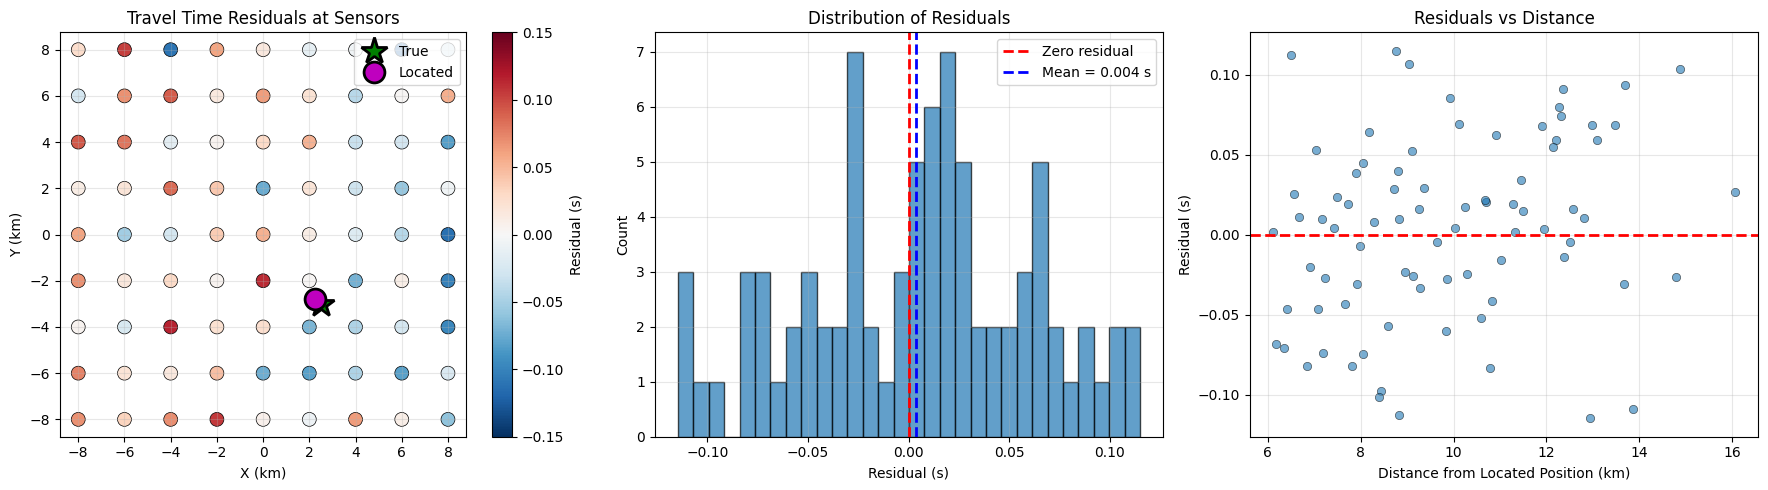

In [17]:
# Plot residuals
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Residuals at sensor locations
ax = axes[0]
scatter = ax.scatter(X_sensors, Y_sensors, c=residuals.reshape(X_sensors.shape), 
                    s=100, cmap='RdBu_r', vmin=-0.15, vmax=0.15,
                    edgecolors='black', linewidths=0.5)
ax.plot(true_eq_x, true_eq_y, 'g*', markersize=20, markeredgecolor='black', 
        markeredgewidth=2, label='True', zorder=10)
ax.plot(optimized_location[0], optimized_location[1], 'mo', markersize=15, 
        markeredgecolor='black', markeredgewidth=2, label='Located', zorder=10)
plt.colorbar(scatter, ax=ax, label='Residual (s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title('Travel Time Residuals at Sensors')
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 2: Histogram of residuals
ax = axes[1]
ax.hist(residuals[~np.isnan(residuals)], bins=30, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero residual')
ax.axvline(np.nanmean(residuals), color='blue', linestyle='--', linewidth=2, 
          label=f'Mean = {np.nanmean(residuals):.3f} s')
ax.set_xlabel('Residual (s)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Residuals')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 3: Residuals vs distance from earthquake
ax = axes[2]
distances = np.sqrt(
    (sensor_coords[:, 0] - optimized_location[0])**2 + 
    (sensor_coords[:, 1] - optimized_location[1])**2 +
    (sensor_coords[:, 2] - optimized_location[2])**2
)
ax.scatter(distances, residuals, alpha=0.6, edgecolors='black', linewidths=0.5)
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Distance from Located Position (km)')
ax.set_ylabel('Residual (s)')
ax.set_title('Residuals vs Distance')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Summary and Discussion

### Key Results:

1. **Forward Problem**: Successfully computed synthetic travel times from a known earthquake using PyKonal
2. **Inverse Problem**: Located earthquake using both grid search and optimization
3. **Uncertainty**: Analyzed location uncertainty and trade-offs

### Important Observations:

- **Depth Uncertainty**: Typically larger than horizontal uncertainty (especially with surface-only sensors)
- **Velocity Model Impact**: Location accuracy depends critically on velocity model accuracy
- **Noise Impact**: Observational noise propagates into location uncertainty
- **Trade-offs**: Strong trade-offs exist between depth and horizontal position

### Extensions to Try:

1. **More realistic noise**: Add systematic timing errors, not just random noise
2. **Incomplete coverage**: Remove some sensors and see how it affects location
3. **Wrong velocity model**: Try locating with a simplified (e.g., homogeneous) velocity model
4. **Multiple events**: Locate several earthquakes and analyze relative location precision
5. **Station corrections**: Account for local site effects at each sensor
6. **Joint inversion**: Simultaneously solve for earthquake location and velocity structure

### Real-World Applications:

- **Earthquake monitoring**: Regional and global seismic networks
- **Induced seismicity**: Monitoring injection-induced earthquakes
- **Microseismic monitoring**: Hydraulic fracturing operations
- **Nuclear monitoring**: Detecting underground nuclear tests
- **Volcano monitoring**: Tracking magma movement

## Exercise Questions

1. **How does the location error depend on noise level?** 
   - Try changing `noise_level` and re-running the location

2. **What if we only had sensors on one side of the earthquake?**
   - Modify `sensor_coords` to only include sensors with x > 0
   - How does this affect location uncertainty?

3. **How important is the velocity model?**
   - Try locating using a homogeneous velocity model (set all velocities to the mean)
   - Compare the location error

4. **What is the minimum number of sensors needed?**
   - Theoretically, you need 4 sensors for 3D location (like GPS)
   - Try using only 4-6 well-distributed sensors

5. **How do different error metrics compare?**
   - Try using L1 norm (mean absolute residual) instead of L2 (RMS)
   - Which is more robust to outliers?

6. **Can you implement a probabilistic location method?**
   - Convert misfit to probability (e.g., assuming Gaussian errors)
   - Create probability density maps instead of just finding the minimum